In [1]:
import numpy as np

user_mat = np.load('result/2/rand/ml1n_20231003_133320/NMF_full_train/user_mat_mf0.npy', allow_pickle=True)

import matplotlib.pyplot as plt
from colour import Color

# blue = Color('purple')
# colors = list(blue.range_to(Color('red'),16))

blue = Color('#2878B5')
colors = list(blue.range_to(Color('#C82423'),16))

# label = {'ml1n': 'ML', 'adn': 'AM'}

def plot(labels=[], n_group=[]):
    assert len(labels) == len(n_group)
    fig = plt.figure()
    fig.set_size_inches(4, 2)
    all_group = np.zeros((max(n_group), len(n_group)))
    for j, n in enumerate(n_group):
        # read data
        data = labels[j]
        group_len = []
        for g_idx in range(n):
            group_len.append(sum(data == g_idx))
        group_len = np.sort(group_len)

        for k in range(n):
            all_group[k, j] = group_len[k] / sum(group_len)

    # plot
    for i in range(len(all_group)):
        y_axis = [str(num) for num in n_group]
        if j == 0:
            plt.barh(y_axis, all_group[i], color=colors[i].hex, edgecolor='white')
        else:
            plt.barh(y_axis, all_group[i], left=all_group[:i].sum(axis=0), color=colors[i].hex, edgecolor='white')

        plt.xticks(size=13, family='Times New Roman')
        plt.yticks(size=13, family='Times New Roman')
        
        plt.xlabel('User percentage', size=15, family='Times New Roman')
        plt.ylabel('Total # of shards', size=15, family='Times New Roman')

    # plt.grid()
    # plt.savefig(f'unbalance_{dataset}.pdf', bbox_inches='tight')

from functools import wraps
import time

def timefn(fn):
    '''compute time cost'''
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        # print(f"@timefn: {fn.__name__} took {t2 - t1: .5f} s")
        print(f"@time: {t2 - t1: .5f} s")
        return result
    return measure_time

In [2]:
print(user_mat.shape)

(6040, 16)


## user embedding

In [3]:
@timefn
def kmeans(X, k, balance=False, max_iters=10):
    # Initialize centroids randomly
    n, _ = X.shape
    group_len = int(np.ceil(n/k))
    centroid = X[np.random.choice(n, size=k, replace=False)]

    # Iterate until convergence or maximum iterations
    for _ in range(max_iters):
        # Assign each sample to the nearest centroid
        dist = ((X - centroid[:, np.newaxis])**2).sum(axis=2)  # [k, n]
        if balance:
            label_count = [group_len] * k
            assinged_sample = []
            label = np.zeros(n)
            inertia = 0
            
            flat_idx_sorted = np.argsort(dist.ravel())[::-1]
            row_idx, col_idx = np.unravel_index(flat_idx_sorted, dist.shape)
            for val, cen_idx, sample_idx in zip(dist[row_idx, col_idx], row_idx, col_idx):
                if len(assinged_sample) == n:
                    break
                if sample_idx in assinged_sample:
                    continue
                if label_count[cen_idx] > 0:
                    label[sample_idx] = cen_idx
                    assinged_sample.append(sample_idx)
                    label_count[cen_idx] -= 1
                    inertia += val
        else:
            label = np.argmin(dist, axis=0)
            inertia = np.min(dist, axis=0).sum()

        # Update centroids to the mean of assigned samples
        new_centroid = np.array([X[label == i].mean(axis=0) for i in range(k)])

        # Check if centroids have converged
        if np.allclose(centroid, new_centroid):
            break

        centroid = new_centroid

    print(f'{inertia:.3f}', end=' ')
    return inertia, label#, centroid

import ot

@timefn
def ot_cluster(X, k, max_iters=10):
    # Initialize centroids randomly
    n, _ = X.shape
    centroid = X[np.random.choice(n, size=k, replace=False)]

    # Iterate until convergence or maximum iterations
    for _ in range(max_iters):
        # compute distance
        dist = ((X - centroid[:, np.newaxis])**2).sum(axis=2)  # [k, n]
        inertia = np.min(dist, axis=0).sum()
        
        # compute sinkhorn distance
        lam = 1e-3
        a = np.ones(n) / n
        b = np.ones(k) / k
        trans = ot.emd(a, b, dist.T, lam)

        # Update centroids to the mean of assigned samples
        label = np.argmax(trans, axis=1)
        new_centroid = np.array([X[label == i].mean(axis=0) for i in range(k)])

        # Check if centroids have converged
        if np.allclose(centroid, new_centroid):
            break

        centroid = new_centroid
    print(f'{inertia:.3f}', end=' ')
    return inertia, label#, centroids

 2 km	> 88878.250 @time:  0.01678 s
 2 ot	> 89032.297 @time:  0.17046 s
 2 bkm	> 104641.654 @time:  5.19992 s

 4 km	> 83872.758 @time:  0.01702 s
 4 ot	> 84023.492 @time:  0.21738 s
 4 bkm	> 110582.271 @time:  10.25773 s

 8 km	> 78372.281 @time:  0.02728 s
 8 ot	> 78436.094 @time:  0.30803 s
 8 bkm	> 122752.797 @time:  20.30915 s

16 km	> 72288.703 @time:  0.04710 s
16 ot	> 72179.969 @time:  0.45074 s
16 bkm	> 139216.720 @time:  40.90749 s



findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

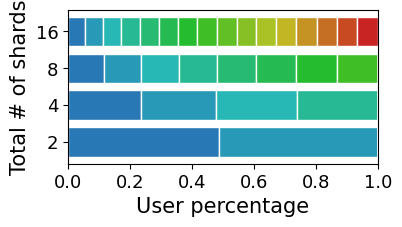

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

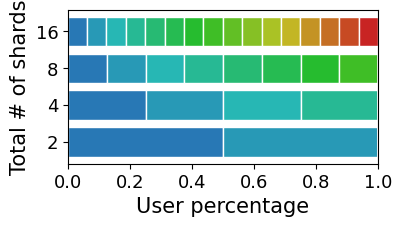

In [4]:
km_labels, bkm_labels, ot_labels = [], [], []
ns = [2, 4, 8, 16]
for i in ns:
    print(f'{i:2d} km', end='\t> ')
    _, label = kmeans(user_mat, i)
    km_labels.append(label)

    print(f'{i:2d} ot', end='\t> ')
    _, label = ot_cluster(user_mat, i)
    ot_labels.append(label)

    print(f'{i:2d} bkm', end='\t> ')
    _, label = kmeans(user_mat, i, True)
    bkm_labels.append(label)
    print()
    
plot(km_labels, ns)
plot(bkm_labels, ns)

## sparse UI mat

In [97]:
from read import readSparseMat
from config import InsParam

param = InsParam('ml1n')
sparse_mat = readSparseMat(param.train_dir, param.n_user, param.n_item)

In [179]:
import warnings
from scipy.sparse import csr_matrix

@timefn
def spa_kmeans(X, k, balanced=False, max_iter=10):
    '''
    X: csr_matrix [n, n_embedding]
    '''
    n, _ = X.shape
    label = np.zeros(n, dtype=int)
    group_len = int(np.ceil(n/k))
    # init
    centroid = X[np.random.choice(n, k, replace=False)].copy()

    e_square = X.multiply(X).sum(axis=1)  # dense mat
    for _ in range(max_iter):
        dist = (-2 * X * centroid.T).A  # dense mat [n, k]
        dist += e_square
        dist += centroid.multiply(centroid).sum(axis=1).reshape(1, -1)  # dense mat

        # kmeans
        if balanced == False:
            new_label = dist.argmin(axis=1)
            inertia = np.sum(dist[np.arange(n), new_label])
        # balanced kmeans
        else:
            new_label = np.zeros_like(label)
            label_count = [group_len] * k
            dist_zip = sortArr(dist)
            assigned = []
            inertia = 0

            flat_idx_sorted = np.argsort(dist.ravel())[::-1]
            row_idx, col_idx = np.unravel_index(flat_idx_sorted, dist.shape)
            for val, sample_idx, cen_idx in zip(dist[row_idx, col_idx], row_idx, col_idx):
                if len(assigned) == n:
                    break
                if sample_idx in assigned:
                    continue
                if label_count[cen_idx] > 0:
                    new_label[sample_idx] = cen_idx
                    assigned.append(sample_idx)
                    label_count[cen_idx] -= 1
                    inertia += val

        if (new_label == label).all():
            break
        label = new_label
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            for j in range(k):
                centroid[j] = csr_matrix(X[label == j].mean(axis=0))
    print(f'{inertia:.3f}', end=' ')
    return inertia, label

@timefn
def spa_ot_cluster(X, k, max_iters=10):
    # Initialize centroids randomly
    n, _ = X.shape
    label = np.zeros(n, dtype=int)
    centroid = X[np.random.choice(n, size=k, replace=False)].copy()

    e_square = X.multiply(X).sum(axis=1)  # dense mat
    # Iterate until convergence or maximum iterations
    for _ in range(max_iters):
        # compute distance
        dist = (-2 * X * centroid.T).A  # dense mat
        dist += e_square
        dist += centroid.multiply(centroid).sum(axis=1).reshape(1, -1)  # dense mat
        
        # compute sinkhorn distance
        lam = 1e-3
        a = np.ones(n) / n
        b = np.ones(k) / k
        trans = ot.emd(a, b, dist, lam)

        # Update centroids to the mean of assigned samples
        new_label = np.argmax(trans, axis=1)
        inertia = np.sum(dist[np.arange(n), new_label])
        # new_centroid = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Check if centroids have converged
        if (new_label == label).all():
            break
        label = new_label
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            for j in range(k):
                centroid[j] = csr_matrix(X[label == j].mean(axis=0))
        
    print(f'{inertia:.3f}', end=' ')
    return inertia, label#, centroids

 2 sparse km	> 402913.188 @time:  0.42915 s
 2 sparse ot	> 414147.688 @time:  0.24949 s
 2 sparse bkm	> 483612.652 @time:  5.93780 s

 4 sparse km	> 388593.281 @time:  0.26135 s
 4 sparse ot	> 397425.500 @time:  0.81239 s
 4 sparse bkm	> 500365.783 @time:  11.36060 s

 8 sparse km	> 376324.156 @time:  0.49823 s
 8 sparse ot	> 382965.375 @time:  1.19611 s
 8 sparse bkm	> 508443.190 @time:  24.03636 s

16 sparse km	> 369023.625 @time:  1.81950 s
16 sparse ot	> 370753.188 @time:  2.69978 s
16 sparse bkm	> 519111.938 @time:  45.94574 s



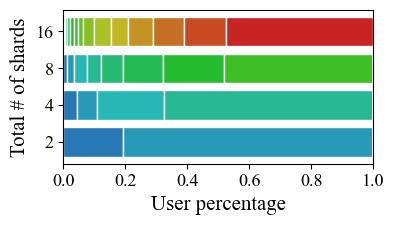

In [180]:
spa_km_labels, spa_bkm_labels = [], []
ns = [2, 4, 8, 16]
for i in ns:
    print(f'{i:2d} sparse km', end='\t> ')
    _, label = spa_kmeans(sparse_mat, i)
    spa_km_labels.append(label)

    print(f'{i:2d} sparse ot', end='\t> ')
    _, label = spa_ot_cluster(sparse_mat, i)
    spa_ot_labels.append(label)
    
    print(f'{i:2d} sparse bkm', end='\t> ')
    _, label = spa_kmeans(sparse_mat, i, True)
    spa_bkm_labels.append(label)
    print()

plot(spa_km_labels, ns)

## emd 2d example

Text(0.5, 1.0, 'Source and target distributions')

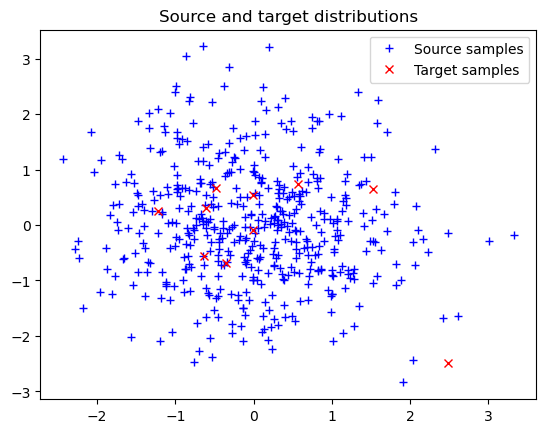

In [101]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

n = 500  # nb samples
m = 10

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([0.5, 0.5])
cov_t = np.array([[1, -.2], [-.2, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(m, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)

pl.figure(1)
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('Source and target distributions')

# pl.figure(2)
# pl.imshow(M, interpolation='nearest')
# pl.title('Cost matrix M')

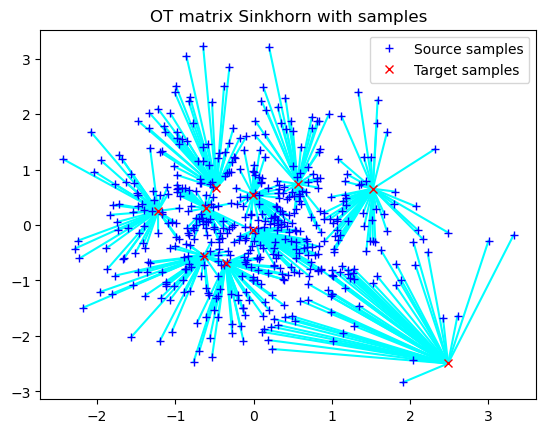

In [102]:
# reg term
lambd = 1e-1

# Gs = ot.sinkhorn(a, b, M, lambd)
Gs = ot.emd(a, b, M, lambd)

# pl.figure(5)
# pl.imshow(Gs, interpolation='nearest')
# pl.title('OT matrix sinkhorn')

pl.figure(6)
ot.plot.plot2D_samples_mat(xs, xt, Gs, color='cyan')#[.5, .5, .5])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix Sinkhorn with samples')

pl.show()